In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import bin_utils as ut
import bin_model_env as me

In [2]:
fnames=[
    # First worm
    'Data/traj12-11-2020_19-04-41.pkl', #none
    'Data/traj12-11-2020_19-14-38.pkl', #none
    'Data/traj12-11-2020_19-24-30.pkl', #xlim 800
    # 'Data/traj12-11-2020_19-35-31.pkl', #none # Seems like an especially bad dataset. Actually ruined all the others
    # Second worm
    'Data/traj12-11-2020_19-55-19.pkl', #none
    'Data/traj12-11-2020_20-05-11.pkl', #none
    'Data/traj12-11-2020_20-15-17.pkl', #none
    'Data/traj12-11-2020_20-25-06.pkl', #xlim 1430
]

xlims = [1e6,1e6,800,1e6,1e6,1e6,1430]

traj_df = ut.make_df(fnames,xlimit=xlims,time_steps=10)
dist_dict = ut.make_dist_dict(traj_df)

In [3]:
class Q_Agent_Base():
    # Following pseudocode from pp131. 
    # Assumes epsilon greedy.
    def __init__(self,
                env,
                gamma=0.98,
                epsilon=0.05,
                q_checkpoint = None,
                ):
        
        # Set hyperparameters and env
        self.gamma = gamma
        self.epsilon = epsilon
        self.obs_n = env.observation_space.n
        self.act_n = env.action_space.n
        
        # Initialize Q table with optimistic starts
        if q_checkpoint is None:
            self.Qtab = np.random.normal(2,.5,size=(self.obs_n, self.act_n))
        else:
            self.Qtab = q_checkpoint
        
        # Initialize other things
        self.eps = 0
        self.steps = 0 # For current episode, not sure if this will be useful
        self.tot_steps = 0
    
    def update(self, obs, action, next_obs, reward):
        raise NotImplementedError
        
    def act(self, obs=None):        
        if obs is None or np.random.random() < self.epsilon:
            # Chooses random action if no observation (first step) OR if epsilon condition passes
            return np.random.choice(self.act_n)
        else:
            # Choose a greedy action
            return np.argmax(self.Qtab[obs,:])          
        
    def eval_act(self, obs):
        if obs is None:
            return np.random.choice(self.act_n)
        else:
            # Choose a greedy action
            return np.argmax(self.Qtab[obs,:])    

In [4]:
class Q_Av_Agent(Q_Agent_Base):
    # Following pseudocode from pp131. 
    # Except using averaging instead of steps, because all these data should be the same.
    def __init__(self,
                env,
                gamma=0.98,
                epsilon=0.05,
                q_checkpoint = None,
                q_counts_checkpoint = None,
                ):
        
        super().__init__(env,
                         gamma=gamma,
                         epsilon=epsilon,
                         q_checkpoint=q_checkpoint)
        
        # Initialize counts matrix
        if q_counts_checkpoint is not None:
            self.Qtab_counts = q_counts_checkpoint
        else:
            self.Qtab_counts = np.zeros((self.obs_n, self.act_n))
    
    def update(self, obs, action, next_obs, reward):
        self.Qtab_counts[obs,action] += 1
        self.Qtab[obs,action] = self.Qtab[obs,action] + \
            (1/self.Qtab_counts[obs,action])*(reward + self.gamma*np.max(self.Qtab[next_obs,:]) - self.Qtab[obs,action])

class Q_Alpha_Agent(Q_Agent_Base):
    # Following pseudocode from pp131. 
    def __init__(self,
                env,
                gamma=0.98,
                epsilon=0.05,
                alpha=0.005,
                q_checkpoint = None,
                q_counts_checkpoint = None,
                ):
        
        super().__init__(env,
                         gamma=gamma,
                         epsilon=epsilon,
                         q_checkpoint=q_checkpoint)
        
        self.alpha = alpha
    
    def update(self, obs, action, next_obs, reward):
        self.Qtab[obs,action] = self.Qtab[obs,action] + \
            self.alpha*(reward + self.gamma*np.max(self.Qtab[next_obs,:]) - self.Qtab[obs,action])

In [5]:
def learner(agent, env,
            episodes = 50000,
            steps_per_ep = 1000,
            eps_per_eval = 1000,
           ):
    # Runs an evaluation episode every so often. Returns average rewards per step for these.
    # Returns average rewards for each episode.
    # Also returns agent.
    
    rewards = np.zeros(episodes)
    eval_rewards = np.zeros((episodes//eps_per_eval)+1)
    
    for ep in range(episodes):
        obs = env.reset()
        reward_vec = np.zeros(steps_per_ep)
        
        for step in range(steps_per_ep):
            action = agent.act(obs)
            next_obs, reward_vec[step], done, info = env.step(action)
            agent.update(obs, action, next_obs, reward_vec[step])
            obs = next_obs
        
        rewards[ep] = np.mean(reward_vec)
        
        # Evaluation episodes
        if ep%eps_per_eval==0 or ep==episodes-1:
            if ep%eps_per_eval==0:
                eval_reward_ind = ep//eps_per_eval
            else:
                eval_reward_ind = -1
            obs = env.reset()
            eval_reward_vec = np.zeros(steps_per_ep)
            
            for step in range(steps_per_ep):
                action = agent.eval_act(obs)
                obs, eval_reward_vec[step], done, info = env.step(action)
                
            eval_rewards[eval_reward_ind] = np.mean(eval_reward_vec)
            print(f'Eval {eval_reward_ind}: average {eval_rewards[eval_reward_ind]}')
    
    return agent, rewards, eval_rewards

In [6]:
toy_worm = me.FakeWorm(dist_dict)
alph_mouse = Q_Alpha_Agent(toy_worm,gamma=0.8)

In [7]:
alph_mouse_learned, rewards, eval_rewards = learner(alph_mouse, toy_worm,
                                                   episodes=2000,
                                                   steps_per_ep=1000,
                                                   eps_per_eval=1000,)

Eval 0: average 8.177612909775943
Eval 1: average 10.166263931211693
Eval -1: average 10.075961448450494


In [9]:
with open('test.json','wb') as f:
    pickle.dump(alph_mouse_learned,f)

In [10]:
with open('test.json','rb') as f:
    mouse_learned = pickle.load(f)

In [17]:
mouse_learned.new = rewards

In [19]:
mouse_learned.new

array([8.15075285, 7.8834332 , 7.58215392, ..., 9.85101985, 9.66367906,
       9.6568091 ])

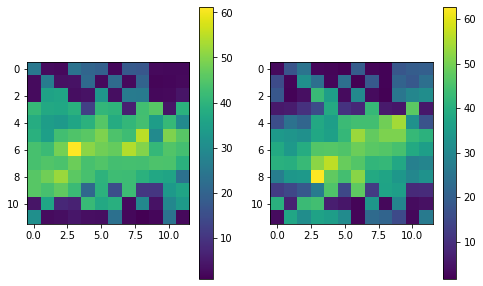

In [11]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches((8,5))
for i in range(2):
    im = ax[i].imshow(alph_mouse_learned.Qtab[:,i].reshape(12,12))
    fig.colorbar(im,ax=ax[i])

# Slurm tests

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys

import utils as ut
import model_env as me
import tab_agents as tab


'''
Setting hyperparameters
'''
i = 150 #int(sys.argv[1])
alphas = [.1, .05, .01, .005, .001]
gammas = [.7, .8, .9, .95, .98]
epsilons = [.1, .05, .01]
runtimes = [1000, 20000]

it = i//150
i -= it*150
alpha_ind = i//30
gamma_ind = (i-(30*alpha_ind))//6
epsilon_ind = (i-30*alpha_ind-6*gamma_ind)//2
runtime_ind = (i-30*alpha_ind-6*gamma_ind-2*epsilon_ind)

alpha = alphas[alpha_ind]
gamma = gammas[gamma_ind]
epsilon = epsilons[epsilon_ind]
runtime = runtimes[runtime_ind]

fbase = './Outputs/Plain_Alpha_A'+str(alpha_ind)+'G'+str(gamma_ind)+'E'+str(epsilon_ind)+'R'+str(runtime_ind)+'iter'+str(it)+'.json'

'''
Making dist dict
'''

fnames=[
    # First worm
    'Data/traj12-11-2020_19-04-41.pkl', #none
    'Data/traj12-11-2020_19-14-38.pkl', #none
    'Data/traj12-11-2020_19-24-30.pkl', #xlim 800
    # 'Data/traj12-11-2020_19-35-31.pkl', #none # Seems like an especially bad dataset. Actually ruined all the others
    # Second worm
    'Data/traj12-11-2020_19-55-19.pkl', #none
    'Data/traj12-11-2020_20-05-11.pkl', #none
    'Data/traj12-11-2020_20-15-17.pkl', #none
    'Data/traj12-11-2020_20-25-06.pkl', #xlim 1430
]

xlims = [1e6,1e6,800,1e6,1e6,1e6,1430]

traj_df = ut.make_df(fnames,xlimit=xlims,time_steps=10)
dist_dict = ut.make_dist_dict(traj_df)


'''
Running the script 
'''
worm = me.FakeWorm(dist_dict)
alph_mouse = tab.Q_Alpha_Agent(worm,gamma=gamma,epsilon=epsilon,alpha=alpha)

alpha_mouse_learned, rewards, eval_rewards = tab.learner(alph_mouse,worm,episodes=runtime)

alpha_mouse_learned.rewards = rewards
alpha_mouse_learned.eval_rewards = eval_rewards
with open(fbase,'wb') as f:
    pickle.dump(alpha_mouse_learned,f)



Eval 0: average 4.577702819392858
Eval -1: average 4.897694062625986


In [3]:
for i in range(750):
    it = i//150
    i -= it*150
    alpha_ind = i//30
    gamma_ind = (i-(30*alpha_ind))//6
    epsilon_ind = (i-30*alpha_ind-6*gamma_ind)//2
    runtime_ind = (i-30*alpha_ind-6*gamma_ind-2*epsilon_ind)

    print(i)
    print('alpha',alpha_ind,'gamma',gamma_ind,'epsilon',epsilon_ind,'runtime',runtime_ind,'iter',it)

0
alpha 0 gamma 0 epsilon 0 runtime 0 iter 0
1
alpha 0 gamma 0 epsilon 0 runtime 1 iter 0
2
alpha 0 gamma 0 epsilon 1 runtime 0 iter 0
3
alpha 0 gamma 0 epsilon 1 runtime 1 iter 0
4
alpha 0 gamma 0 epsilon 2 runtime 0 iter 0
5
alpha 0 gamma 0 epsilon 2 runtime 1 iter 0
6
alpha 0 gamma 1 epsilon 0 runtime 0 iter 0
7
alpha 0 gamma 1 epsilon 0 runtime 1 iter 0
8
alpha 0 gamma 1 epsilon 1 runtime 0 iter 0
9
alpha 0 gamma 1 epsilon 1 runtime 1 iter 0
10
alpha 0 gamma 1 epsilon 2 runtime 0 iter 0
11
alpha 0 gamma 1 epsilon 2 runtime 1 iter 0
12
alpha 0 gamma 2 epsilon 0 runtime 0 iter 0
13
alpha 0 gamma 2 epsilon 0 runtime 1 iter 0
14
alpha 0 gamma 2 epsilon 1 runtime 0 iter 0
15
alpha 0 gamma 2 epsilon 1 runtime 1 iter 0
16
alpha 0 gamma 2 epsilon 2 runtime 0 iter 0
17
alpha 0 gamma 2 epsilon 2 runtime 1 iter 0
18
alpha 0 gamma 3 epsilon 0 runtime 0 iter 0
19
alpha 0 gamma 3 epsilon 0 runtime 1 iter 0
20
alpha 0 gamma 3 epsilon 1 runtime 0 iter 0
21
alpha 0 gamma 3 epsilon 1 runtime 1 iter 

alpha 3 gamma 0 epsilon 1 runtime 1 iter 1
94
alpha 3 gamma 0 epsilon 2 runtime 0 iter 1
95
alpha 3 gamma 0 epsilon 2 runtime 1 iter 1
96
alpha 3 gamma 1 epsilon 0 runtime 0 iter 1
97
alpha 3 gamma 1 epsilon 0 runtime 1 iter 1
98
alpha 3 gamma 1 epsilon 1 runtime 0 iter 1
99
alpha 3 gamma 1 epsilon 1 runtime 1 iter 1
100
alpha 3 gamma 1 epsilon 2 runtime 0 iter 1
101
alpha 3 gamma 1 epsilon 2 runtime 1 iter 1
102
alpha 3 gamma 2 epsilon 0 runtime 0 iter 1
103
alpha 3 gamma 2 epsilon 0 runtime 1 iter 1
104
alpha 3 gamma 2 epsilon 1 runtime 0 iter 1
105
alpha 3 gamma 2 epsilon 1 runtime 1 iter 1
106
alpha 3 gamma 2 epsilon 2 runtime 0 iter 1
107
alpha 3 gamma 2 epsilon 2 runtime 1 iter 1
108
alpha 3 gamma 3 epsilon 0 runtime 0 iter 1
109
alpha 3 gamma 3 epsilon 0 runtime 1 iter 1
110
alpha 3 gamma 3 epsilon 1 runtime 0 iter 1
111
alpha 3 gamma 3 epsilon 1 runtime 1 iter 1
112
alpha 3 gamma 3 epsilon 2 runtime 0 iter 1
113
alpha 3 gamma 3 epsilon 2 runtime 1 iter 1
114
alpha 3 gamma 4 eps

alpha 0 gamma 1 epsilon 0 runtime 0 iter 3
7
alpha 0 gamma 1 epsilon 0 runtime 1 iter 3
8
alpha 0 gamma 1 epsilon 1 runtime 0 iter 3
9
alpha 0 gamma 1 epsilon 1 runtime 1 iter 3
10
alpha 0 gamma 1 epsilon 2 runtime 0 iter 3
11
alpha 0 gamma 1 epsilon 2 runtime 1 iter 3
12
alpha 0 gamma 2 epsilon 0 runtime 0 iter 3
13
alpha 0 gamma 2 epsilon 0 runtime 1 iter 3
14
alpha 0 gamma 2 epsilon 1 runtime 0 iter 3
15
alpha 0 gamma 2 epsilon 1 runtime 1 iter 3
16
alpha 0 gamma 2 epsilon 2 runtime 0 iter 3
17
alpha 0 gamma 2 epsilon 2 runtime 1 iter 3
18
alpha 0 gamma 3 epsilon 0 runtime 0 iter 3
19
alpha 0 gamma 3 epsilon 0 runtime 1 iter 3
20
alpha 0 gamma 3 epsilon 1 runtime 0 iter 3
21
alpha 0 gamma 3 epsilon 1 runtime 1 iter 3
22
alpha 0 gamma 3 epsilon 2 runtime 0 iter 3
23
alpha 0 gamma 3 epsilon 2 runtime 1 iter 3
24
alpha 0 gamma 4 epsilon 0 runtime 0 iter 3
25
alpha 0 gamma 4 epsilon 0 runtime 1 iter 3
26
alpha 0 gamma 4 epsilon 1 runtime 0 iter 3
27
alpha 0 gamma 4 epsilon 1 runtime 1 i

alpha 1 gamma 4 epsilon 0 runtime 1 iter 4
56
alpha 1 gamma 4 epsilon 1 runtime 0 iter 4
57
alpha 1 gamma 4 epsilon 1 runtime 1 iter 4
58
alpha 1 gamma 4 epsilon 2 runtime 0 iter 4
59
alpha 1 gamma 4 epsilon 2 runtime 1 iter 4
60
alpha 2 gamma 0 epsilon 0 runtime 0 iter 4
61
alpha 2 gamma 0 epsilon 0 runtime 1 iter 4
62
alpha 2 gamma 0 epsilon 1 runtime 0 iter 4
63
alpha 2 gamma 0 epsilon 1 runtime 1 iter 4
64
alpha 2 gamma 0 epsilon 2 runtime 0 iter 4
65
alpha 2 gamma 0 epsilon 2 runtime 1 iter 4
66
alpha 2 gamma 1 epsilon 0 runtime 0 iter 4
67
alpha 2 gamma 1 epsilon 0 runtime 1 iter 4
68
alpha 2 gamma 1 epsilon 1 runtime 0 iter 4
69
alpha 2 gamma 1 epsilon 1 runtime 1 iter 4
70
alpha 2 gamma 1 epsilon 2 runtime 0 iter 4
71
alpha 2 gamma 1 epsilon 2 runtime 1 iter 4
72
alpha 2 gamma 2 epsilon 0 runtime 0 iter 4
73
alpha 2 gamma 2 epsilon 0 runtime 1 iter 4
74
alpha 2 gamma 2 epsilon 1 runtime 0 iter 4
75
alpha 2 gamma 2 epsilon 1 runtime 1 iter 4
76
alpha 2 gamma 2 epsilon 2 runtime 